In [6]:
# install Python Wavelet if you dont have
!pip install PyWavelets

In [24]:
import numpy as np
import pywt
import cv2
import os
import matplotlib
from matplotlib import pyplot as plt

In [21]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

## Check the Wavelet Transfrom methos if its working or not

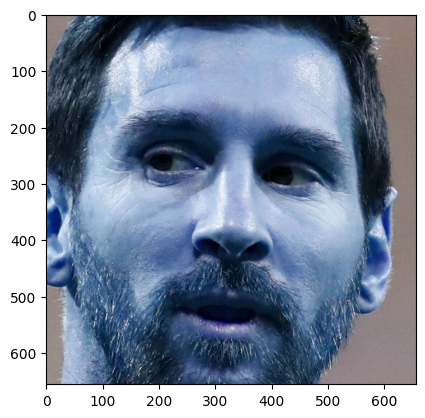

In [31]:
cropped_img = cv2.imread('dataset_cropped/lionel_messi/lionel_messi1.jpg')
plt.imshow(cropped_img, cmap='gray')

[[  0   1   2 ...   0   2   3]
 [  0   0   1 ...   0   1   3]
 [  1   1   0 ...   0   1   3]
 ...
 [248 247 247 ...   1   1   1]
 [250 249 247 ...   2   0   0]
 [249 248 247 ...   1 255 252]]


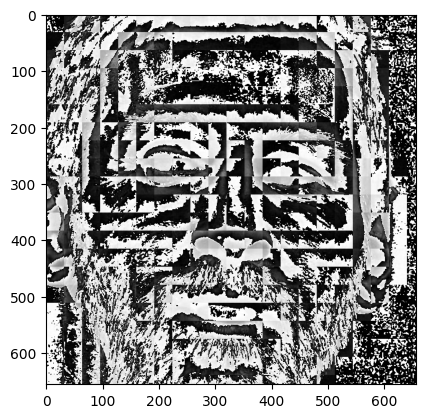

In [34]:
im_wave = w2d(cropped_img, 'db1', 5)
plt.imshow(im_wave, cmap='gray')

In [149]:
path_to_faces = './dataset_cropped'
players_names =[]
players_name_dict = {}

for player_folder in os.scandir(path_to_faces):
    if player_folder.is_dir():
        players_names.append(player_folder.name)
        players_name_dict[player_folder.name] = []
    for img_path in os.scandir(player_folder.path):
        players_name_dict[player_folder.name].append(img_path.path)

# players_names
# players_name_dict[players_names[0]]
# players_name_dict
# players_name_dict.keys() will also contain the name of the players


### Now we have a dictionary players_name_dict that contains player names as a key and player images paths as a values

### Lets cound how many images we have for each football player

In [150]:
count_dict = {}
count = 0
for player_name in players_name_dict.keys():
    count = 0
    for pl_img in players_name_dict[player_name]:
        count +=1
    count_dict[player_name] = count

count_dict

{'lionel_messi': 61,
 'Son_Heung_min': 46,
 'cristiano_ronaldo': 78,
 'karim_benzema': 42,
 'kylian_mbappe': 90}

In [192]:
class_dict = {}
count = 0
for player_name in players_name_dict.keys():
    class_dict[player_name] = count
    count = count + 1
class_dict

{'lionel_messi': 0,
 'Son_Heung_min': 1,
 'cristiano_ronaldo': 2,
 'karim_benzema': 3,
 'kylian_mbappe': 4}

## lets stack raw image i.e png and the wavelet image together (prepare it for training and testing)

In [151]:
X, y = [], []

for player_name, training_files in players_name_dict.items():
    for img_path in training_files:
        img = cv2.imread(img_path)
        if img is None:
            continue
        scalled_img = cv2.resize(img, (64,64))
        img_wav = w2d(img, 'db1', 5)
        scalled_img_wav= cv2.resize(img_wav, (64,64))
        img_stacked = np.vstack((scalled_img.reshape(64*64*3,1), scalled_img_wav.reshape(64 * 64, 1)))
        X.append(img_stacked)
#         y.append(class_dict[player_name])
        y.append(list(players_name_dict).index(player_name))

# Convert X values into float to enter the model
# print(len(X[0]))
X = np.array(X).reshape(len(X), (64 * 64 * 3 + 64*64)).astype(float)
#print(X.shape)
    

### we go our X (image data) and y(labales)
## No we will use SVM with rbf kernel to Train our model

In [152]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'linear', C = 1))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.85

In [163]:
for pl_name in players_name_dict.keys():
    print(pl_name, list(players_name_dict).index(pl_name))

lionel_messi 0
Son_Heung_min 1
cristiano_ronaldo 2
karim_benzema 3
kylian_mbappe 4


In [170]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.65      0.76        17
           1       0.91      1.00      0.95        10
           2       0.87      0.91      0.89        22
           3       0.77      1.00      0.87        10
           4       0.81      0.81      0.81        21

    accuracy                           0.85        80
   macro avg       0.85      0.87      0.86        80
weighted avg       0.86      0.85      0.85        80



## Use GridSearch to try out diferent models with different paramenters (1. Svm, 2. random forest, 3. logistic regression) The goals is to find the best model with best fine tuned parameters

In [164]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [165]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [166]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.860993,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.650177,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.852216,{'logisticregression__C': 1}


In [168]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [171]:
best_estimators['svm'].score(X_test, y_test)

0.85

### Lets Explore the svm result a bit

In [176]:
best_clf = best_estimators['svm']

# Lets Plot the data and see the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[11,  1,  1,  2,  2],
       [ 0, 10,  0,  0,  0],
       [ 0,  0, 20,  0,  2],
       [ 0,  0,  0, 10,  0],
       [ 1,  0,  2,  1, 17]])

### Lets use a seaborn library to draw confusion matrix a bit clear

Text(95.72222222222221, 0.5, 'Truth')

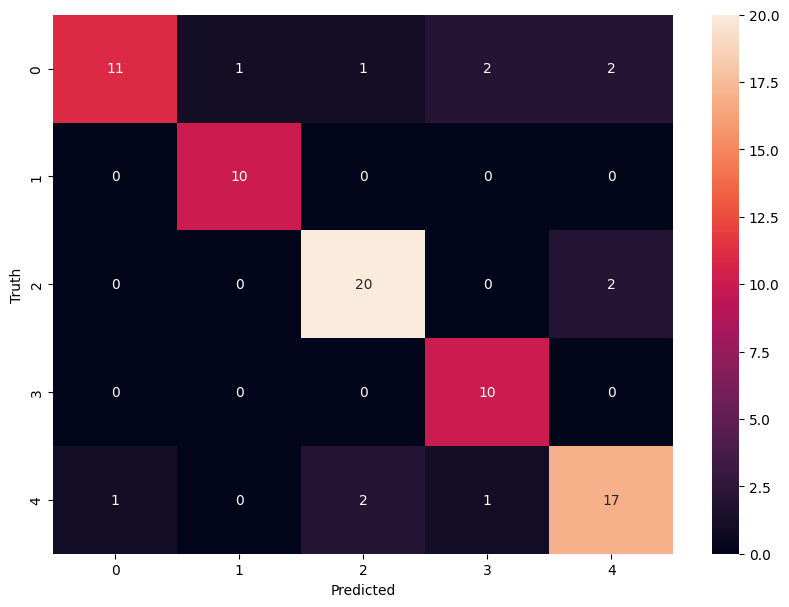

In [184]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Lets Save the model using pickle

In [186]:
!pip install joblib
import joblib
# save the model now
joblib.dump(best_clf, 'svm_model.pkl')

['svm_model.pkl']

In [193]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

In [194]:
!gio open .